<a href="https://colab.research.google.com/github/gmrwh92/Machine-Learning-Deep-Learning/blob/main/Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of Sentiment Classification Accuracy

# **Introduction**

This project aims to evaluate and compare the performance of various models for sentiment classification using text data.

Main Goal
* Data cleaning using NLP
 - As the dataset consists of text, data cleaning and preprocessing are essential steps before model development.
* Model Development for Prediction
  - Implement supervised machine learning models, including Naive Bayes, Multinomial Logistic Regression, Random Forest Classifier, and K-Nearest Neighbors.
  - Implement a deep learning model using Long Short-Term Memory (LSTM).
  * Model Comparison
  - Assess and compare the accuracy of each model across different dataset to determine the most effective approach for sentiment classification.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## importing libraries
import re
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk.tag import pos_tag

from sklearn import metrics
from sklearn.metrics import log_loss, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn



# **Description of Dataset**

The dataset used in this project is a widely recognized resource for customer sentiment analysis, comprising the ID, text, and corresponding sentiment labels. To prepare the data for model training, we will convert the sentiment labels into numerical values: neutral as 0, positive as 1, and negative as 2.  Our ultimate goal is to compare the accuracy of various models using this pre-processed text data

In [3]:
## load dataset
df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [4]:
## check the balance of labels
value_counts = df['sentiment'].value_counts()
print(value_counts)

sentiment
1    25000
0    25000
Name: count, dtype: int64


We will clean the dataset using NLP techniques, including removing stopwords that do not influence sentiment and converting all words to lowercase. While we are not identifying the sentiment of each sentence ourselves, our focus is to evaluate how well each model can train on the text data and predict the pre-labeled sentiment. The cleaning process is essential to ensure consistency and to prevent the model from treating variations of the same word differently (e.g., "Sad" vs. "sad").

In [5]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [6]:
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # 기본값

In [7]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def data_preprocessing(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub('<.*?>', '', text)  #
        text = ''.join([c for c in text if c not in string.punctuation])

        words = word_tokenize(text)
        words = pos_tag(words)
        words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in words if word not in stop_words]

        text = ' '.join(words)
    else:
        text = ''
    return text

df['cleaned_reviews'] = df['review'].apply(data_preprocessing)
df.head()

,review,sentiment,cleaned_reviews
0,One of the other reviewers has mentioned that ...,1,one reviewer mention watch 1 oz episode youll ...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,0,basically theres family little boy jake think ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...


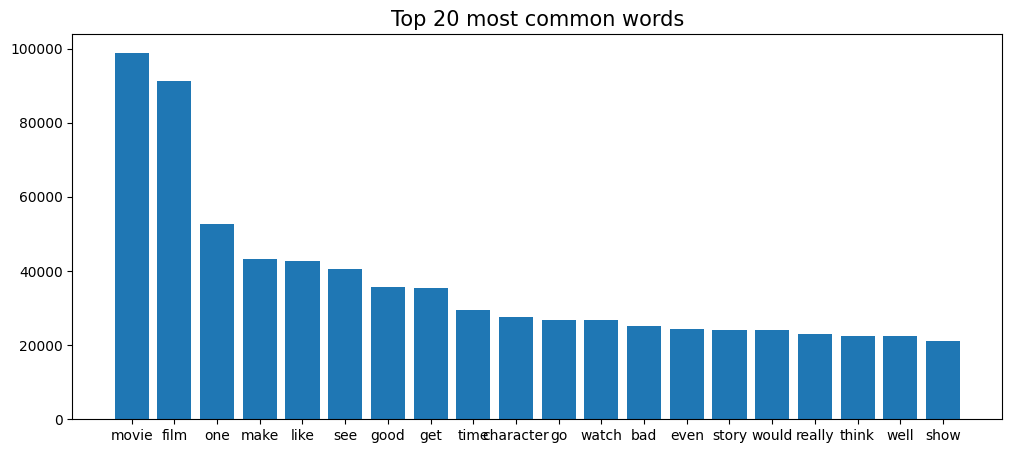

In [8]:
## Make a plot to see the most common used words
corpus = [word for text in df['cleaned_reviews'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common()
keys = []
values = []
for key, value in sorted_words[:20]:
    keys.append(key)
    values.append(value)

plt.figure(figsize=(12, 5))
plt.bar(keys, values)
plt.title('Top 20 most common words', size=15)
plt.show()

In [9]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

reviews_int = []
for text in df['cleaned_reviews']:
    r = [vocab_to_int[word] for word in text.split()]
    reviews_int.append(r)


count    50000.000000
mean       119.841500
std         90.089954
min          3.000000
25%         64.000000
50%         89.000000
75%        146.000000
max       1429.000000
Name: Review_len, dtype: float64


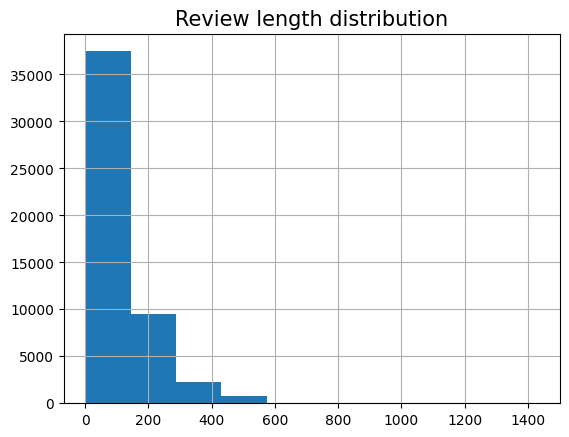

In [10]:
## Make a histogram to show the lenghts of text in our dataset
review_len = [len(x) for x in reviews_int]
df['Review_len'] = review_len
print(df['Review_len'].describe())

df['Review_len'].hist()
plt.title('Review length distribution', size=15)
plt.show()

# **Fit supervised learning models (Multinomial Naive Bayes, Logistic Regression, K Nearest Neighbors and Random Forest)**


In [11]:
## converts a collection of text documents into a bag-of-words (BoW) representation
cv = CountVectorizer()
text_counts = cv.fit_transform(df['cleaned_reviews'])

In [12]:
## split dataset into train and test set
X=text_counts
y=df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=30)

In [24]:
## fit Multinomial Naive Bayes
## calculate the probability of a document belonging to a specific class (e.g., positive or negative sentiment).
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_train_prob = mnb.predict_proba(X_train)
y_test_prob = mnb.predict_proba(X_test)

# Training Loss & Validation Loss
mnbtrain_loss = log_loss(y_train, y_train_prob)
mnbtest_loss = log_loss(y_test, y_test_prob)

# Accuracy
mnbtrain_acc = accuracy_score(y_train, mnb.predict(X_train))
mnbtest_acc = accuracy_score(y_test, mnb.predict(X_test))


print(f" Multinomial Naive Bayes")
print(f"Training Loss: {mnbtrain_loss:.4f}, Validation Loss: {mnbtest_loss:.4f}")
print(f"Training Accuracy: {mnbtrain_acc:.4f}, Validation Accuracy: {mnbtest_acc:.4f}")

 Multinomial Naive Bayes
Training Loss: 0.4805, Validation Loss: 1.0523
Training Accuracy: 0.9175, Validation Accuracy: 0.8553


In [23]:
## fit Logistic Regression
## the model outputs the probability of each class and selects the class with the highest probability as the predicted sentiment
LR=LogisticRegression(max_iter=500)
LR.fit(X_train, y_train)
y_train_prob = LR.predict_proba(X_train)
y_test_prob = LR.predict_proba(X_test)
train_loss = log_loss(y_train, y_train_prob)
test_loss = log_loss(y_test, y_test_prob)
train_acc = accuracy_score(y_train, LR.predict(X_train))
test_acc = accuracy_score(y_test, LR.predict(X_test))
print(f" Logistic Regression")
print(f"Training Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}")
print(f"Training Accuracy: {train_acc:.4f}, Validation Accuracy: {test_acc:.4f}")

 Logistic Regression
Training Loss: 0.0468, Validation Loss: 0.3560
Training Accuracy: 0.9966, Validation Accuracy: 0.8844


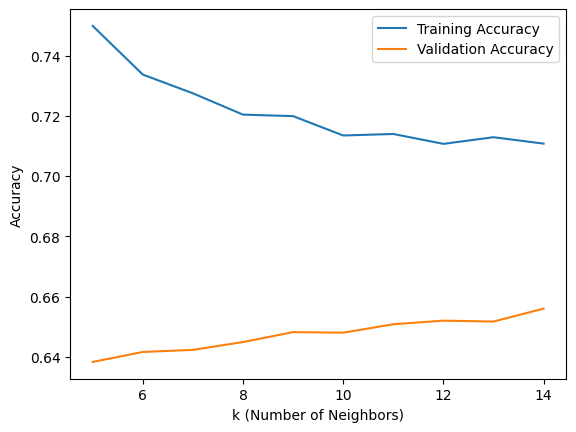

In [15]:
## fit KNN
## type of instance-based learning where the algorithm memorizes the training dataset and makes predictions by finding the "nearest" data points (neighbors) to a given input.

k_values = range(5, 15)
train_accuracies = []
val_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, knn.predict(X_train))
    val_acc = accuracy_score(y_test, knn.predict(X_test))

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

plt.plot(k_values, train_accuracies, label='Training Accuracy')
plt.plot(k_values, val_accuracies, label='Validation Accuracy')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [16]:
## fit simple random forest
## ensemble learning algorithm that builds multiple decision trees and combines their outputs. It works well for text classification tasks when you have a mix of features.


rf = RandomForestClassifier(n_estimators=100, random_state=123456)
rf.fit(X_train, y_train)


train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)


test_pred = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)


print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {test_accuracy:.4f}")




Training Accuracy: 1.0000
Validation Accuracy: 0.8523


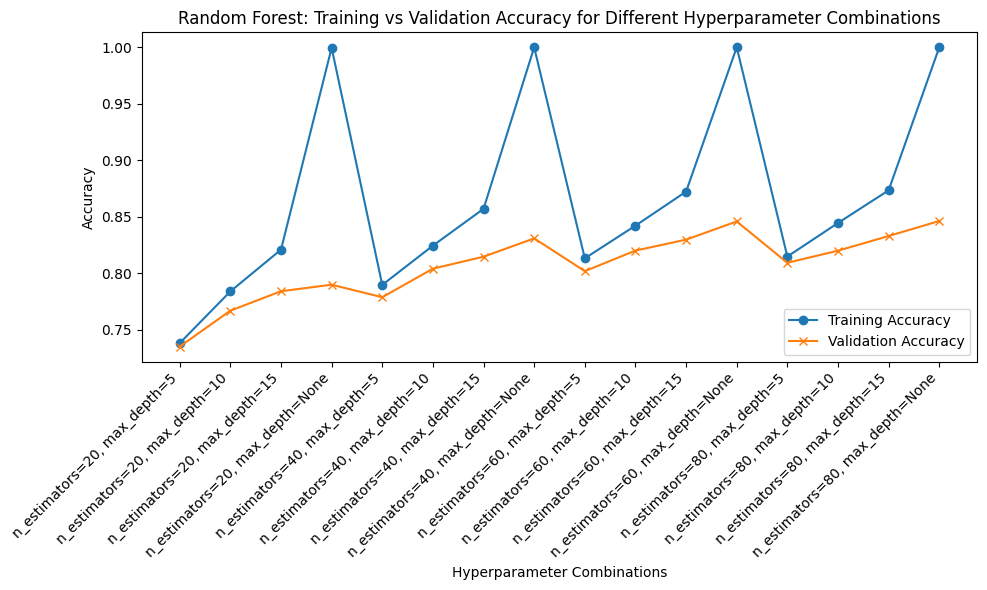

In [17]:
##randomforest with different hyperparamaters
n_estimators_values = [20, 40, 60, 80]
max_depth_values = [5, 10, 15, None]


train_accuracies = []
val_accuracies = []


for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=123456)
        rf.fit(X_train, y_train)


        train_acc = accuracy_score(y_train, rf.predict(X_train))

        val_acc = accuracy_score(y_test, rf.predict(X_test))

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)


labels = [f"n_estimators={n}, max_depth={d}" for n in n_estimators_values for d in max_depth_values]


plt.figure(figsize=(10, 6))
plt.plot(labels, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(labels, val_accuracies, label='Validation Accuracy', marker='x')


plt.xlabel('Hyperparameter Combinations')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.title('Random Forest: Training vs Validation Accuracy for Different Hyperparameter Combinations')


plt.tight_layout()
plt.show()



# ** Adjust hyperparameter to avoid overfitting

In [21]:
## fit Logistic Regression
## the model outputs the probability of each class and selects the class with the highest probability as the predicted sentiment
LR=LogisticRegression(C= 0.001, max_iter=500)
LR.fit(X_train, y_train)
y_train_prob = LR.predict_proba(X_train)
y_test_prob = LR.predict_proba(X_test)
train_loss = log_loss(y_train, y_train_prob)
test_loss = log_loss(y_test, y_test_prob)
train_acc = accuracy_score(y_train, LR.predict(X_train))
test_acc = accuracy_score(y_test, LR.predict(X_test))
print(f" Logistic Regression with regularization")
print(f"Training Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}")
print(f"Training Accuracy: {train_acc:.4f}, Validation Accuracy: {test_acc:.4f}")

 Logistic Regression with regularization
Training Loss: 0.3875, Validation Loss: 0.4002
Training Accuracy: 0.8681, Validation Accuracy: 0.8516


In [22]:
## fit Multinomial Naive Bayes
## calculate the probability of a document belonging to a specific class (e.g., positive or negative sentiment).
mnb = MultinomialNB(alpha=6)
mnb.fit(X_train, y_train)
y_train_prob = mnb.predict_proba(X_train)
y_val_prob = mnb.predict_proba(X_test)
# Training Loss & Validation Loss
train_loss = log_loss(y_train, y_train_prob)
val_loss = log_loss(y_test, y_val_prob)
train_acc = accuracy_score(y_train, mnb.predict(X_train))
val_acc = accuracy_score(y_test, mnb.predict(X_test))
print(f" Multinomial Naïve Bayes with smoothing")
print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

 Multinomial Naïve Bayes with smoothing
Training Loss: 0.6623, Validation Loss: 0.9631
Training Accuracy: 0.8858, Validation Accuracy: 0.8539


In [20]:
# Evaluate the model
#calculating accuracy score on test set for each model
print("Acc on test set with Multinomial Naive Bayes:", MNBaccuracy_score)
print("Acc on test set with Logistic Regression:", lraccuracy_score)
print("Acc on test set with K Nearest Neighbors:", knnaccuracy_score)
print("Acc on test set with Random Forest:", rfaccuracy_score)

NameError: name 'MNBaccuracy_score' is not defined

## **LSTM**
Padding in LSTMs (Long Short-Term Memory networks) is a technique used to ensure that input sequences have uniform lengths, which is required for batch processing in neural networks. LSTMs are designed to handle sequences of variable lengths, but during training, batches of data are processed simultaneously to improve computational efficiency.


In [ ]:
def Padding(review_int, seq_len):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return features

In [ ]:
## make it as 200 because lots of text were under 200 words.
features = Padding(reviews_int, 200)

In [ ]:
## split train and test
X_train, X_remain, y_train, y_remain = train_test_split(features, df['sentiment'].to_numpy(), test_size=0.20,random_state=30)
X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.2, random_state=1)
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

# dataloaders
batch_size = 32

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [ ]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)  # Change dataiter.next() to next(dataiter)

In [ ]:
class sentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        #embedding and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        #stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # Dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        #sigmoid function
        sig_out = self.sigmoid(out)

        # reshape to be batch size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 64
hidden_dim = 256
n_layers = 2

model = sentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)

print(model)

In [ ]:
lr=0.001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    for inputs, labels in train_loader:
        # Get the actual batch size for each iteration
        batch_size = inputs.size(0)
        # Initialize hidden state with the correct batch size
        h = model.init_hidden(batch_size)

        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # ... [rest of your training loop] ...

    val_h = model.init_hidden(batch_size)  # Initialize hidden state with the correct batch size
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        # Get the actual batch size for each iteration
        batch_size = inputs.size(0)
        # Initialize hidden state with the correct batch size
        val_h = model.init_hidden(batch_size)

        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output,labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')


In [ ]:
test_losses = [] # track loss
num_correct = 0

model.eval()
# iterate over test data
for inputs, labels in test_loader:
    # Get the actual batch size for each iteration
    batch_size = inputs.size(0)
    # Initialize hidden state with the correct batch size
    test_h = model.init_hidden(batch_size)

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    test_h = tuple([each.data for each in test_h])

    inputs, labels = inputs.to(device), labels.to(device)

    output, test_h = model(inputs, test_h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

In [ ]:
# Visualize the results of comparion
accuracy = []
accuracy = [MNBaccuracy_score, lraccuracy_score, knnaccuracy_score, rfaccuracy_score, test_acc]
model = ['Multinomial Naive Bayes', 'Logistic Regression', 'KNN', 'Random Forest', 'LSTM']
plt.barh(model,accuracy)

# **Results**
Random Forest, Logistic Regression, and Multinomial Naive Bayes performed well, achieving over 80% accuracy in correctly classifying instances. This strong performance is due to their advantages: Random Forest handles complex patterns effectively with its ensemble method, Logistic Regression works well for linearly separable data, and Multinomial Naive Bayes is particularly suited for discrete or text-based features.<br>

On the other hand, K-Nearest Neighbors (KNN) and Long Short-Term Memory (LSTM) models did not perform as well. KNN may have struggled because it is sensitive to high-dimensional data and requires clear decision boundaries. LSTM, which is designed for sequential data, might have been less effective if the dataset lacked sequential patterns and also requires more data and computational resources to achieve good results. This shows the importance of choosing models that match the data's characteristics and computational limits.